In [1]:
import os
import random

import torch as th
from torch import nn, optim
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from PIL import Image
from pathlib import Path
from utils import train, plot_loss_curves, pred_and_plot_image

device = 'cuda' if th.cuda.is_available() else 'cpu'
device, th.__version__

('cuda', '1.13.1')

In [2]:
data_path = Path("data/")
image_path = data_path / "lemon"

In [3]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'data\lemon'.
There are 0 directories and 951 images in 'data\lemon\bad_quality'.
There are 0 directories and 452 images in 'data\lemon\empty_background'.
There are 0 directories and 1125 images in 'data\lemon\good_quality'.


data\lemon\empty_background\empty_background_403.jpg
empty_background
300
300


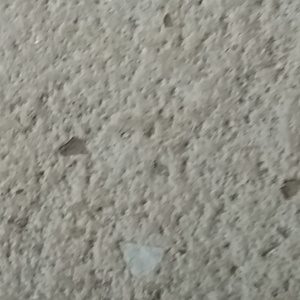

In [4]:
img_path_list = list(image_path.glob('*/*.jpg'))
random_img = random.choice(img_path_list)
img_class = random_img.parent.stem
img = Image.open(random_img)

print(random_img)
print(img_class)
print(img.height)
print(img.width)
img

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.RandomVerticalFlip(p=.5),
    transforms.ToTensor()
])

In [6]:
dataset = datasets.ImageFolder(root=image_path,
                               transform=data_transform)
dataset

Dataset ImageFolder
    Number of datapoints: 2528
    Root location: data\lemon
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )

In [7]:
class_names = dataset.classes
class_names

['bad_quality', 'empty_background', 'good_quality']

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, test_size])

len(train_dataset), len(test_dataset)

(2022, 506)

In [9]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

len(train_dataloader), len(test_dataloader)

(127, 32)

In [10]:
class TinyModel(nn.Module):
    def __init__(self, input_shape: int, hidden: int, output_shape: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden,
                      kernel_size=5,
                      bias=False),
            nn.BatchNorm2d(hidden),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden,
                      out_channels=hidden,
                      kernel_size=3,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(hidden),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,
                      out_channels=hidden,
                      kernel_size=3),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(32), nn.ReLU(),
            nn.Dropout(.445),
            nn.LazyLinear(out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.maxpool(x)
        x = self.conv_block2(x)
        x = self.maxpool(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [11]:
th.manual_seed(31)
th.cuda.manual_seed(31)

NUM_EPOCHS = 5

model_0 = TinyModel(3, 12, len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=3e-4)

C:\Users\baris\anaconda3\envs\lemon_quality\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
summary(model_0, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyModel                                [1, 3]                    --
├─Sequential: 1-1                        [1, 12, 220, 220]         --
│    └─Conv2d: 2-1                       [1, 12, 220, 220]         900
│    └─BatchNorm2d: 2-2                  [1, 12, 220, 220]         24
│    └─ReLU: 2-3                         [1, 12, 220, 220]         --
├─MaxPool2d: 1-2                         [1, 12, 109, 109]         --
├─Sequential: 1-3                        [1, 12, 107, 107]         --
│    └─Conv2d: 2-4                       [1, 12, 109, 109]         1,296
│    └─BatchNorm2d: 2-5                  [1, 12, 109, 109]         24
│    └─ReLU: 2-6                         [1, 12, 109, 109]         --
│    └─Conv2d: 2-7                       [1, 12, 107, 107]         1,308
│    └─ReLU: 2-8                         [1, 12, 107, 107]         --
├─MaxPool2d: 1-4                         [1, 12, 53, 53]           --
├─Sequen

In [13]:
model_0_results = train(model_0,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn,
                        NUM_EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
 Time: 11.107 | Train loss: 0.3724 | Train acc: 0.8479 | Test loss: 0.6298 | Test acc: 0.7719
Epoch: 2
 Time: 10.969 | Train loss: 0.1828 | Train acc: 0.9385 | Test loss: 0.2660 | Test acc: 0.8777
Epoch: 3
 Time: 10.778 | Train loss: 0.1172 | Train acc: 0.9592 | Test loss: 0.0493 | Test acc: 0.9863
Epoch: 4
 Time: 10.660 | Train loss: 0.1048 | Train acc: 0.9636 | Test loss: 0.0452 | Test acc: 0.9844
Epoch: 5
 Time: 10.602 | Train loss: 0.1090 | Train acc: 0.9592 | Test loss: 0.0359 | Test acc: 0.9883


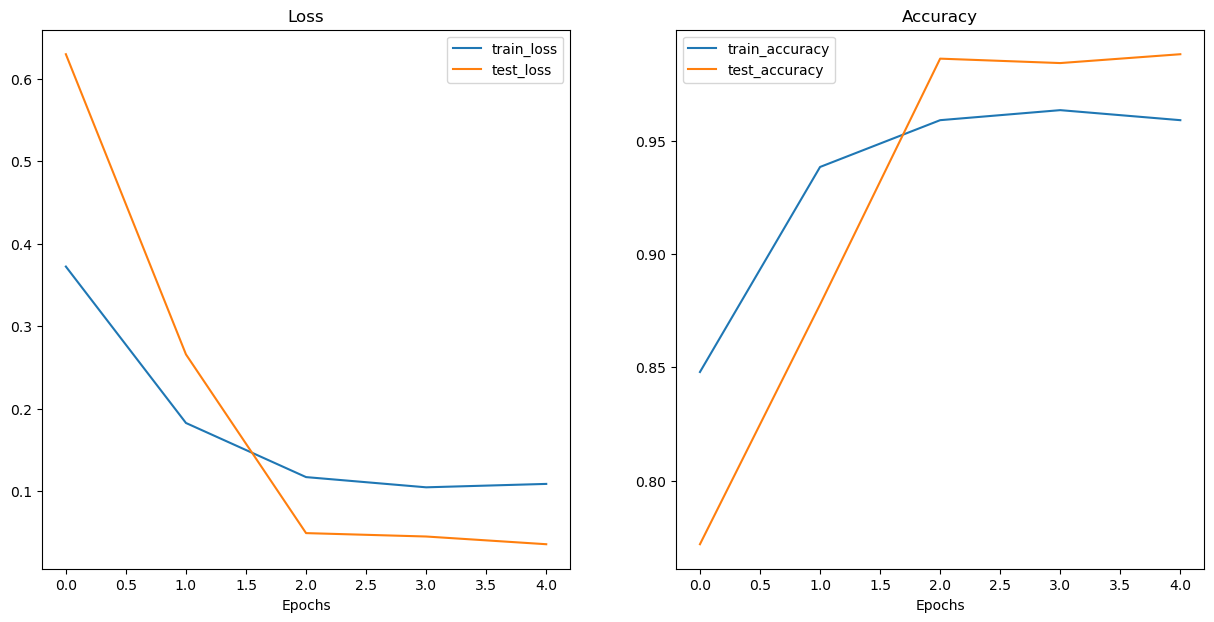

In [14]:
plot_loss_curves(model_0_results)

In [15]:
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(224, 224))
])

good_quality


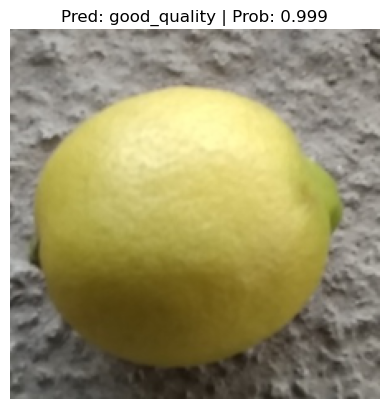

In [16]:
# Setup custom image path
custom_image_path = random.choice(img_path_list)
print(custom_image_path.parent.stem)

# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform)